## Configure

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import requests
import json
import pprint
import time
from tqdm import tqdm

import statsmodels

import re
# import kss
# from pykospacing import spacing
# from hanspell import spell_checker
# from soynlp.normalizer import *

# from khaiii import KhaiiiApi

# import wordcloud

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
mpl.rc("font", family='AppleGothic')
mpl.rc("axes", unicode_minus=False)

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

FONT_PATH = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

## EDA

code가 쇼핑몰에서 사용하는 id 이므로 code를 키로 사용할 것을 염두해두어야한다.

평점

- 가설/근거
    - 후기량/증가량과 판매증가량 -> 주문 데이터를 가져와야해서 패스...
        - 후기량이 늘어날 수록 판매량 증가폭이 증가한다.
            - 특정(포토, 글자수 많은 등) 의 후기로 좁히기
        - 어느 정도
    - 초기 리뷰가 전체 리뷰에 영향을 가장 많이 끼친다? -> 주문 데이터를 가져와야해서 패스...
        - 새로운 고객이 리뷰를 쓸 때 기존의 리뷰들을 보고 쓰기 때문에 기존 리뷰의 동향이 해당 고객에게 영향을 미칠 수 있다.
        - 기간과 섞어야한다.
         
    - 구매 시점과 후기 시점 사이의 간격 -> 주문 데이터를 가져와야해서 패스...
        - 리뷰를 작성하면 다음 리뷰까지의 기간이 짧다(구매한다.)
        - 간격이 클 수록 평점이 낮아진다.
        - 글자가 많아지거나 적어진다.
        - 일정 기간내에 고객이 리뷰를 쓰도록 만들어야 한다.
    - 조회수 또는 구매에 영향을 많이 끼치는 후기 -> 로그...

In [ ]:
reviews.info()

In [ ]:
plt.figure(figsize=(15, 8))

sns.heatmap(data=reviews.corr(), cmap='GnBu')

In [ ]:
# profile = pandas_profiling.ProfileReport(review_df)
# profile.to_file("profiled_review_since_20190101.html")

### columns : id & code

In [ ]:
reviews[['id', 'code']].info()

In [ ]:
reviews[reviews['code'].notnull()]

리뷰마다 부여된 고유 값. 중복은 없다. code는 <리뷰 고유 번호 - 상품 고유 번호> 형식으로 되어 있다.

- 문제점 : code에 NaN 값이 많고 상품 번호가 엮여 있어 key로 사용하기 힘들다.
- 이유 : ..? 관리 문제..?
- 대안 : 다른 값들을 조합하여 key로 사용? 가령 user_code, product_code

### columns : user_id, user_code, user_name

In [ ]:
reviews['user_id'].nunique(), reviews['user_code'].nunique(), reviews['user_name'].nunique()

In [ ]:
duplicted_name_list = list(set(reviews['user_name']) & set(reviews['user_code']))

pd.options.display.max_rows = 1000

reviews[reviews['user_name'].isin(duplicted_name_list)][lambda x : ~x['user_name'].str.contains("엠디|md")].shape

비어있는 값은 없다. 이름은 동명이인이 있을 수 있기 때문에 값의 종류가 더 적다. 

- 고객의 id를 코드로 쓰는것도 있는듯하다. 딱봐도 아이디인것들이 있다...

- 다만 id와 코드가 6개정도 차이가 나는데 아마 실험용 id일듯?
    - [ ] 매칭하여 확인
    
    
- 지그재그 구매자, 오드 직원(MD, CS)이 보인다. 전자는 지그재그에서 넘어오는 id를 처리하지 못한 것 같고 후자는 오드 직원들의 솔직?한 후기 전략상 넣어놓은 것 같다. 
     - 오드 MD 는 name에 '사내판매' 또는 md 또는 '엠디' 가 포함되어 있고, 메세지에 '오드 MD'가 포함되어 있다.
     
- user_name과 user_code가 겹치는 경우가 있다. 약 900개
    - 대부분 '오드 MD' 또는 '지그재그구매자' 이다. 겹치는 것 있음.  
    - 엠디도 아니고 지그재그도 아닌 글들은..?

### columns : created_at

In [ ]:
plt.figure(figsize=(18, 8))

sns.pointplot(data=reviews[reviews['source'].str.contains("sms")]
              , x='created_at(hour)', y='id', estimator=np.size, hue='created_at(dayofweek)')

In [ ]:
plt.figure(figsize=(18, 8))

sns.pointplot(data=reviews, x='created_at(hour)', y='id', estimator=np.size, hue='created_at(dayofweek)')

전반적으로 퇴근시간 이후에 리뷰량이 많아진다.

월요일 출근시간대 8시에 리뷰가 많다...? 

- 사내판매(직원)은 19명 밖에 안된다.
- 중복되는 사람이 꽤 있다. 
- 출근하며 리뷰를 작성하는듯...? -> 사진이 없는게 대부분이지만 약 15퍼센트 정도는 사진이 있다.

토요일 낮에 많이 올라온다. 리뷰를 몰아서 작성하나?

In [ ]:
reviews.loc[reviews['created_at(hour)'] == 8, 'user_code'].value_counts().head(10)

In [ ]:
reviews.loc[reviews['created_at(hour)'] == 8, 'images_count'].value_counts().head(10)

In [ ]:
sns.countplot(data=reviews, x='created_at(dayofweek)')

월/화에 주문하면 수/목요일에 도착해서 리뷰가 많아진다?

금요일은 퇴근하고 노느라 리뷰가 상대적으로 낮아진다.

토요일은 쉬는날이고 몰아서 리뷰를 작성?

일요일은 쉬자.

### columns : message

In [ ]:
reviews['message(cleaned)'] = reviews['message'].str.strip()\
                                                .str.replace("\n", " ")

reviews['message(cleaned)'].head()

In [ ]:
reviews['message_length'] = reviews['message(cleaned)'].apply(len)

cols = ['message', 'message(cleaned)', 'message_length']
reviews[cols].head()

In [ ]:
reviews['message_length'].describe()

In [ ]:
plt.figure(figsize=(18, 4))

sns.distplot(reviews['message_length'], bins=1000)

In [ ]:
sns.boxplot(reviews['message_length'], whis=3)

In [ ]:
reviews.loc[reviews['message_length'] > 1000]

In [ ]:
c1 = reviews['user_code'] == 'uuuuuq4245'
c2 = reviews['message'].str.contains("정말 실망")

for review in reviews.loc[c1&c2, 'message(cleaned)']:
    print(review, end='\n')

- 1000자가 넘는 리뷰는 거의 없다. 1000자가 넘는 리뷰의 90퍼 이상은 한 명(uuuuuq4245)이 쓴 부정적리뷰가 반복적으로 삭제된 기록이다.

대충쓴 리뷰
- 
중립 리뷰 특징

긍정/부정 리뷰별 키워드 빈도수

- '사이즈는 맞는데' 처럼 반전이 있을 수 있다...
- 사이즈, 길이, 기장, 재질, 품질, 원단, 촉감, 소재, 보풀, 이염, 세탁, 터지, 터진, 터졌, 마감 

In [ ]:
word_list = ['사이즈', '길이', '기장', '재질', '품질', '원단', '촉감', '소재', '보풀', '이염', '세탁', '터지', '터진', '터졌', '마감']

positive_review_893017 = positive_reviews[reviews['product_code'] == 893017]


word_count_dict = {}

for word in word_list:
    word_count = positive_review_893017['message(cleaned)'].str.contains(word).sum()
    
    word_count_dict[word] = word_count


word_count_dict

In [ ]:
plt.figure(figsize=(18, 6))

plt.bar(word_count_dict.keys(), word_count_dict.values())

In [ ]:
# 부정은 전체 리뷰에서 뽑아본다.
word_list = ['사이즈', '길이', '기장', '재질', '품질', '원단', '촉감', '소재', '보풀', '이염', '세탁', '터지', '터진', '터졌', '마감']

# negative_review_893017 = negative_reviews[reviews['product_code'] == 893017]


word_count_dict = {}

for word in word_list:
    word_count = negative_reviews['message(cleaned)'].str.contains(word).sum()
    
    word_count_dict[word] = word_count


word_count_dict

In [ ]:
plt.figure(figsize=(18, 6))

plt.bar(word_count_dict.keys(), word_count_dict.values())

In [ ]:
# negative_reviews[negative_reviews['message(cleaned)'].str.contains("세탁|이염|보풀|터지|터진|길이|기장|사이즈")]

negative_reviews[negative_reviews['message(cleaned)'].str.contains("원단|재질|품질|촉감|소재")].head()

In [498]:
negative_reviews.loc[12152]['message']

'싼게 비지떡이네요..\n오늘 처음 입었는데\n산걸 엄청 후회 했어요\n소재가 좋은게 아니다 보니\n입고 반나절 있었는데\n옷이 틀어지고\n늘어나고 하네요\n사지 마세요\n정말 후회해요'

### columns : score

In [ ]:
# 평점 분포...
tmp = reviews.pivot_table(index='product_code', values='score', aggfunc=['mean', 'std', 'count'])

tmp.columns = ["-".join(col) for col in tmp.columns]

tmp.sort_values("mean-score")

In [ ]:
plt.figure(figsize=(18, 5))

sns.distplot(tmp['mean-score'], bins=100)

In [ ]:
plt.figure(figsize=(18, 5))

sns.barplot(data=positive_reviews, x='images_count', y='score')

In [ ]:
positive_reviews.pivot_table(index='images_count', values='score', aggfunc=['mean', 'std', 'count'])

In [ ]:
plt.figure(figsize=(18, 5))

sns.barplot(data=negative_reviews, x='images_count', y='score')

- [ ] 유의미한 평균 차이가 있는지 검정
    - 이미지 1개 이하, 초과로 나누어(2그룹) 나누어서도 검정
    
- 이 리뷰들이 고객의 어떤 행동에 영향을 미치는지를 알아야한다 ㅠ
- 사실상 이미지가 많은 1점은 -1점과 같은효과?! 많은 이미지가 달린 부정적 리뷰를 빠르게 캐치해서 응대해준다 -> 리뷰 수정 또는 삭제 -> 영향 줄어듬?

In [ ]:
positive_reviews['images_count'].value_counts()

검정을 해봐야 되지만...얼추 결론이 나온 것 같다. 부정적 리뷰의 경우 사진까지 올릴 케이스면 극대노 케이스인듯..!

In [ ]:
negative_reviews['images_count'].value_counts()

In [ ]:
negative_reviews['message_length(bin_10)'] = negative_reviews['message_length'] // 30 * 30

plt.figure(figsize=(9, 18))

sns.barplot(data=negative_reviews, y='message_length(bin_10)', x='score', orient='h')

In [ ]:
reviews['score'].describe()

- 전체 평점 평균은 굉장히 높다 -> 상품이 좋아서 쓰는 사람이 많다. 불만을 쓰는 사람이 적다(쇼핑몰 측이 삭제하거나...정말 없거나)

In [ ]:
# reviews['product_code'].value_counts().value_counts(normalize=True).sort_index() * 100
reviews['product_code'].value_counts().value_counts(normalize=True).sort_index().cumsum() * 100

In [ ]:
# 리뷰가 10개 미만인 상품들
tmp = reviews[reviews['product_code'].isin(reviews['product_code'].value_counts()[lambda x : x < 10].index)]

# tmp.pivot_table(index='created_at(year-month)', columns='product_code', values='score', aggfunc='count').fillna(0)

In [ ]:
reviews.pivot_table(index='created_at(year-month)', values='score', aggfunc='count')

리뷰가 10개 이하인 상품이 전체 80%

리뷰가 없거나 적은 이유

- 최근에 등록된 상품
- 인기가 없는 상품?

In [ ]:
positive_reviews['message_length'].describe()

In [ ]:
negative_reviews['message_length'].describe()

### columns : product_options

약 10000개가 비어있음.

In [ ]:
reviews['source'].value_counts()

In [ ]:
tmp = reviews[reviews['product_options'] == '{}']

print(tmp.shape)
tmp['source'].value_counts()

비어있는 것들의 source 는 모두 copied...!

In [ ]:
reviews['product_options(cleaned)'] = reviews['product_options'].replace("{}", np.nan)

cols = ['product_options', 'product_options(cleaned)']
reviews[cols].head()

In [ ]:
s = "{'색상': '아이보리', '사이즈': 'Free(55~66)'}"

json.loads(s.replace("'", "\""))

In [437]:
def get_product_color(product_options):
    if pd.isnull(product_options):
        return product_options
    else:
        options = json.loads(product_options.replace("'", "\""))
        if '색상' in options:
            return options['색상']
        else :
            return np.nan
        
def get_product_size(product_options):
    if pd.isnull(product_options):
        return product_options
    else:
        options = json.loads(product_options.replace("'", "\""))
        if '사이즈' in options:
            return options['사이즈']
        else :
            return np.nan

In [ ]:
reviews['product_options(color)'] = reviews['product_options(cleaned)'].apply(get_product_color)
reviews['product_options(size)'] = reviews['product_options(cleaned)'].apply(get_product_size)

cols = ['product_options(color)', 'product_options(size)', 'product_options']
reviews[cols].head()

In [ ]:
reviews['product_options(color)'].isnull().sum()

In [ ]:
reviews['product_options(color)'].value_counts()

In [ ]:
pivot_table = reviews.pivot_table(index='product_options(color)', values='score', aggfunc=['mean', 'count', 'std'])

pivot_table.columns = ['-'.join(col) for col in pivot_table.columns]

pivot_table[lambda x : x['count-score'] > 100].sort_values('mean-score', ascending=False)

처리해주기 전까진 큰 의미를 찾기 힘들듯. 블랙이 압도적으로 많긴하다.

처리필요. 묶어주기도

In [ ]:
pivot_table = reviews.pivot_table(index='product_options(size)', values='score', aggfunc=['mean', 'count', 'std'])

pivot_table.columns = ['-'.join(col) for col in pivot_table.columns]

pivot_table[lambda x : x['count-score'] > 100].sort_values('mean-score', ascending=False)

### columns : likes_count, plus_like_count

likes_count : <이 글이 도움이 되었나요?> 의 클릭된 '네' 의 숫자? 

In [ ]:
cols = ['score', 'message_length', 'likes_count', 'plus_likes_count', 'comments_count']

reviews[cols].corr()

likes_count, plus_like_count 는 상관관계가 높다. 

comments_count, score가 좀 의외이다. 부정적리뷰의 경우 긍정적에 비해 comments_count가 1인 비율이 높아서 그런듯(긍정적은 0 비율이 높다)

In [ ]:
reviews[reviews['likes_count'] > 10]

### colunns : comments_count

리뷰에 달린 댓글수. 최대 11

가끔 오드가 댓글을 다는데 5줄이 이상의 성의있는 리뷰(적립금 기준에 부합하는)에만 댓글을 달아준다. 그래서 댓글이 1인것이 굉장히 많다.

특히 부정적 리뷰에 댓글이 1인것이 많다. 오드가 열심히 달아주는 듯

-> 글자수가 많고 comment가 1개이면 오드에서 달았을 확률이 높다.

In [ ]:
reviews[reviews['comments_count'] > 1]

In [ ]:
negative_reviews['comments_count'].value_counts()

In [ ]:
sns.barplot(data=reviews, x='comments_count', y='message_length')

In [ ]:
sns.barplot(data=reviews, x='comments_count', y='score')

In [ ]:
reviews[reviews['comments_count'] > 3]['score'].value_counts()

In [ ]:
negative_reviews['comments_count'].value_counts()

In [ ]:
positive_reviews['comments_count'].value_counts()

부정적 리뷰에 오드에서 열심히 댓글달아주고 있는 듯하다

### columns : source

- 웹 후기 vs 모바일후기
    - 웹 후기가 기본적으로 후기가 길 것이다. 
        - 웹이라 긴건지, 길게 쓸려고 웹인건지의 선후관계가 명확하지 않아서 후순위

In [ ]:
reviews['source'].value_counts()

- 특정 시점 이후에 등록된 상품만
- 오드 직원의 평점은 제외
- 중복 제거

In [ ]:
reviews.loc[reviews['source'].str.contains("mobile"), 'source(binary)'] = 'mobile'
reviews.loc[reviews['source'].str.contains("pc"), 'source(binary)'] = 'pc'

cols = ['source', 'source(binary)']
reviews[cols].head()

# reviews['source(binary)'] = reviews['source'].str.contains("mobile")

In [ ]:
reviews.pivot_table(index='source(binary)', values=['images_count', 'message_length'], aggfunc=['count', 'mean', 'std'])

copied 의 경우 데이터를 업데이트하면서 그대로 옮겨와서 그럴수도? created와 update 날짜의 차이가 크다?

이미지를 올리려고 PC를 이용하는지 vs PC를 이용하니 이미지를 올리게 되는지

전자에 한표...

In [ ]:
plt.figure(figsize=(18, 8))

sns.pointplot(data=reviews[reviews['source'].str.contains("mobile")],
             x='created_at(hour)', y='id', estimator=np.size, hue='created_at(dayofweek)')

In [ ]:
plt.figure(figsize=(18, 8))

sns.pointplot(data=reviews[reviews['source'].str.contains("pc")],
             x='created_at(hour)', y='id', estimator=np.size, hue='created_at(dayofweek)')

In [ ]:
sns.countplot(data=reviews[reviews['source'].str.contains("pc")], x='created_at(hour)')

### cross sign

주식 매매 기법중 골든 크로스와 데드 크로스 기법과 유사한 방식으로 최근 점수의 상승/하락 추세를 구할 것이다.

In [ ]:
pivot_table = reviews.pivot_table(index='created_at(date)', columns='product_code', values='score', aggfunc='count').fillna(0)

pivot_table.head()

In [ ]:
rolling_5 = pivot_table[881774].rolling(window=5).mean()
rolling_20 = pivot_table[881774].rolling(window=20).mean()

tmp = (rolling_5 - rolling_20)

# 하루 전에는 5일봉이 더 작다.
c1 = tmp.shift(1) < 0

# 당일에는 5일봉 더 크거나 같다.
c2 = tmp >= 0

golden_cross = c1&c2

golden_cross[golden_cross].index

In [485]:
def get_golden_cross_sign(product_code, pivoted_reviews, short_term=5, long_term=20):
    rolling_short = pivoted_reviews[product_code].rolling(window=short_term).mean()
    rolling_long = pivoted_reviews[product_code].rolling(window=long_term).mean()
    
    short_minus_long = rolling_short - rolling_long
    
    sign_yesterday = short_minus_long.shift(1) < 0
    sign_today = short_minus_long >= 0
    
    sign_golden_cross = sign_yesterday & sign_today
    
    # 날짜만 반환
    return sign_golden_cross[sign_golden_cross].index


def get_dead_cross_sign(product_code, pivoted_reviews, short_term=5, long_term=20):
    rolling_short = pivoted_reviews[product_code].rolling(window=short_term).mean()
    rolling_long = pivoted_reviews[product_code].rolling(window=long_term).mean()
    
    short_minus_long = rolling_short - rolling_long
    
    sign_yesterday = short_minus_long.shift(1) > 0
    sign_today = short_minus_long <= 0
    
    sign_dead_cross = sign_yesterday & sign_today
    
    # 날짜만 반환
    return sign_dead_cross[sign_dead_cross].index

In [ ]:
get_golden_cross_sign(893017, pivot_table)

In [ ]:
get_dead_cross_sign(893017, pivot_table)

In [ ]:
reviews.groupby('product_code')['id'].size().sort_values()

In [ ]:
sns.countplot(data=reviews[reviews['product_code'] == 893017], y='created_at(date)')

로직 추가
- 관측할 기간 설정 : 원본 데이터를 자르고 시작
- 단기, 장기 기준 설정 : ..
- 리뷰량이 너무 적은 것들은 한 두개가 달려도 크로스 신호가 발생할 수 있다.
    - 최소 리뷰량 지정
        - 일정 기간의 누적량을 기준으로해도 될 듯

- 최근 혹은 매일 갱신 : 매일 리뷰데이터 갱신 후 골든크로스 확인.
    - 이동평균 구한걸 저장해서 연산의 중복을 피한다.
 
- 크로스가 발생한 상품 정보 표시
    - 누적 리뷰수 그래프
    - 판매량, 
    - 쇼핑몰에게 먼저 보여줘야할 상품은 무엇일지 기준 정하기(정렬기준)
        - 판매량 비교

    - 상품 정보

### Power Reviewer

또는 고객 등급 지표 뽑기

In [ ]:
tmp = reviews.pivot_table(index='user_code', values=['message_length', 'images_count'], aggfunc=['count', 'mean'])

tmp.columns = ['-'.join(col) for col in tmp.columns]

tmp = tmp.drop(columns=['count-images_count']).rename(columns={"count-message_length" : "count"})

c1 = tmp['mean-message_length'] > 100

c2 = tmp['count'] > 3

tmp[c1&c2]

In [ ]:
# 사진을 단 댓글 뽑고 개수와 비율 표시
# 직원은 제외
reviews['images_count(bool)'] = reviews['images_count'] > 0

tmp2 = reviews.pivot_table(index='user_code', values='images_count(bool)', aggfunc=['sum', 'count'])

tmp2['ratio'] = tmp2.iloc[:, 0] / tmp2.iloc[:, -1]

c3 = tmp2['ratio'] > 0.5

power_reviewer_list = (c1&c2&c3)[c1&c2&c3].index

drop_list = reviews.loc[reviews['user_name'].str.contains("사내판매|CS|MD|odemd|오드"), 'user_code'].unique()

power_reviewer_list = power_reviewer_list[~power_reviewer_list.str.contains("odemd|MD|엠디|사내판매|CS")]

power_reviewer_list = list(set(power_reviewer_list) - set(drop_list))

print(len(power_reviewer_list))
power_reviewer_list[:5]

## Preprocessing(Text 위주)

### ordinal, datetime, etc

- datetime
- nan

In [ ]:
reviews['created_at(review)'] = pd.to_datetime(reviews['created_at(review)'])
reviews['updated_at(review)'] = pd.to_datetime(reviews['updated_at(review)'])

cols = ['created_at(review)', 'updated_at(review)']
reviews[cols].head()

In [ ]:
reviews['created_at(year)'] = reviews['created_at(review)'].dt.year
reviews['created_at(month)'] = reviews['created_at(review)'].dt.month
reviews['created_at(day)'] = reviews['created_at(review)'].dt.day
reviews['created_at(hour)'] = reviews['created_at(review)'].dt.hour

reviews['created_at(year-month)'] = reviews['created_at(review)'].dt.strftime("%Y-%m")
reviews['created_at(date)'] = reviews['created_at(review)'].dt.date

reviews['created_at(dayofweek)'] = reviews['created_at(review)'].dt.dayofweek

cols = ['created_at(year-month)', 'created_at(year)', 'created_at(month)', 'created_at(day)', 'created_at(hour)',
       'created_at(dayofweek)']
reviews[cols].head()

### text process

1. 불필요한 문자 삭제  
2. 띄어쓰기  
3. 맞춤법  
4. 외래어 대체
5. 이상하게 쓴 리뷰 처리
 - 귀찮아서 'd' 이렇게 아무 문자나 넣어놓은 것. 현재는 빈 문자열로 처리되고 있음.
6. tokenizing / stemming
   
- 한 리뷰내에서 문장 쪼개기는 진행하지 않고 아래 진행 -> 문장을 안나누는 것과 유의미한 결과가 있을까..?
- 감정 레이블 달기
    - 중간은 nan으로 하고 나중에 예측
- 불용어 처리는 후순위로

### 감정 Label 달기

In [6]:
def label_positive_emotion(score):
    if score > 3:
        return 1
    elif score < 3:
        return 0
    else:
        return np.nan

In [7]:
reviews['is_positive'] = reviews['score'].apply(label_positive_emotion)

cols = ['score', 'is_positive']
reviews[cols].head()

,score,is_positive
0,1,0.0
1,5,1.0
2,5,1.0
3,5,1.0
4,5,1.0


#### 토큰화하기 전에 . 을 제거해주면 안되나? 토큰화, 클리닝 순서가 어느정도 중요할지..

### 처리 - 기호 및 공백 제거, 맞춤법, 토큰화

In [ ]:
# 외래어 사전 만들기
cols = ['left', 'right', 'tmp']

lownword_data = pd.read_csv('data/confused_loanwords.txt', sep='\t', header=None, names=cols)

lownword_map = dict(zip(lownword_data['left'], lownword_data['left'] ))

lownword_map

In [76]:
# 기호,
def preprocess_text(text): 
    # 기호처리
    cleaned_text = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\^]', ' ', text)
    # ㅎㅎ, ㅋㅋ도 의미가 있는 것으로 분석될까..?!
    # cleaned_text = re.sub(r'[ㅂㅈㄷㄱㅅㅛㅕㅑㅐㅔㅁㄴㅇㄹㅎㅗㅓㅏㅣㅋㅌㅊㅍㅠㅜㅡㅃㅉㄸㄲㅆㅕㅑㅒㅖ]', '', text) 
    cleaned_text = cleaned_text.replace("~"," ")
    cleaned_text = re.sub(r'^\w\s', '', cleaned_text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) 
    cleaned_text = cleaned_text.strip()
    
    # 띄어쓰기
    cleaned_text = spacing(cleaned_text)
    
    # 맞춤법 체크
    spelled_text = spell_checker.check(cleaned_text)
    cleaned_text = spelled_text.checked
    
    # 문장 토큰화 -> 

    # cleaned_text = kss.split_sentences(cleaned_text)


    # 외래어 변환
    # for lownword in lownword_map:
    #    cleaned_text = cleaned_text.replace(lownword, lownword_map[lownword])

    cleaned_text = repeat_normalize(cleaned_text)
    
    return cleaned_text



def tokenize_text(text):
    significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']

    api = KhaiiiApi()
    token = ''
    
    try:
        for word in api.analyze(text):
            for morph in word.morphs:
                if morph.tag in significant_tags:
                    token += morph.lex + '/' + morph.tag + ' '
    except:
        return token

    token = stem_text(token.strip())
        
    for tag in significant_tags:
        token = token.replace(tag, "")
    
    token = token.replace("/", '')
 
    return token



def stem_text(text):
    p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
    p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
    p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
    p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
    
    ori_sent = text
    
    mached_terms = re.findall(p1, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        modi_terms += '다/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    mached_terms = re.findall(p2, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            if tag != 'VX':
                modi_terms += lemma
        modi_terms += '다/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    mached_terms = re.findall(p3, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        if '다' != modi_terms[-1]:
            modi_terms += '다'
        modi_terms += '/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    mached_terms = re.findall(p4, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        if '다' != modi_terms[-1]:
            modi_terms += '다'
        modi_terms += '/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)
    return ori_sent


# 불 용어 처리가 필요한데 케이스가 너무 많아 힘들듯하다. 간단하게만 진행해보자.

In [72]:
# 분할해서 단계 추적하기
def divide_process(data, n):
    result = []
    max_length = data.shape[0]
    
    try:
        for i in tqdm(range(1, max_length // n + 2)):
            start_index = (i - 1) * n
            end_index = i * n

            result.append(data.iloc[start_index : end_index]['message'].apply(preprocess_text).apply(tokenize_text))

            print(f"{max_length // n}분할 -> {i} 번째까지 처리 완료")
            
    except:
        pass

    return pd.concat(result), i

In [74]:
tokenized_reviews, last_index = divide_process(reviews, 1000)

print(tokenized_reviews.shape)
tokenized_reviews.head()

  1%|          | 1/111 [02:23<4:22:13, 143.03s/it]

110분할 -> 1 번째까지 처리 완료


  2%|▏         | 2/111 [04:41<4:17:13, 141.59s/it]

110분할 -> 2 번째까지 처리 완료


  3%|▎         | 3/111 [07:05<4:16:02, 142.25s/it]

110분할 -> 3 번째까지 처리 완료


  4%|▎         | 4/111 [09:23<4:11:26, 140.99s/it]

110분할 -> 4 번째까지 처리 완료


  5%|▍         | 5/111 [11:39<4:06:32, 139.56s/it]

110분할 -> 5 번째까지 처리 완료


  5%|▌         | 6/111 [13:58<4:04:11, 139.54s/it]

110분할 -> 6 번째까지 처리 완료


  6%|▋         | 7/111 [16:30<4:08:26, 143.33s/it]

110분할 -> 7 번째까지 처리 완료


  7%|▋         | 8/111 [19:06<4:12:20, 146.99s/it]

110분할 -> 8 번째까지 처리 완료


  8%|▊         | 9/111 [21:36<4:11:10, 147.75s/it]

110분할 -> 9 번째까지 처리 완료


  9%|▉         | 10/111 [23:57<4:05:19, 145.73s/it]

110분할 -> 10 번째까지 처리 완료


 10%|▉         | 11/111 [26:15<3:59:04, 143.45s/it]

110분할 -> 11 번째까지 처리 완료


 11%|█         | 12/111 [28:43<3:58:57, 144.83s/it]

110분할 -> 12 번째까지 처리 완료


 12%|█▏        | 13/111 [31:03<3:54:20, 143.48s/it]

110분할 -> 13 번째까지 처리 완료


 13%|█▎        | 14/111 [33:28<3:52:51, 144.04s/it]

110분할 -> 14 번째까지 처리 완료


 14%|█▎        | 15/111 [35:52<3:50:15, 143.92s/it]

110분할 -> 15 번째까지 처리 완료


 14%|█▍        | 16/111 [38:15<3:47:23, 143.62s/it]

110분할 -> 16 번째까지 처리 완료


 15%|█▌        | 17/111 [40:35<3:43:15, 142.51s/it]

110분할 -> 17 번째까지 처리 완료


 16%|█▌        | 18/111 [43:00<3:42:00, 143.23s/it]

110분할 -> 18 번째까지 처리 완료


 17%|█▋        | 19/111 [45:21<3:38:38, 142.59s/it]

110분할 -> 19 번째까지 처리 완료


 18%|█▊        | 20/111 [47:35<3:32:33, 140.15s/it]

110분할 -> 20 번째까지 처리 완료


 19%|█▉        | 21/111 [49:55<3:29:59, 140.00s/it]

110분할 -> 21 번째까지 처리 완료


 20%|█▉        | 22/111 [52:11<3:25:41, 138.66s/it]

110분할 -> 22 번째까지 처리 완료


 21%|██        | 23/111 [54:26<3:22:04, 137.78s/it]

110분할 -> 23 번째까지 처리 완료


 22%|██▏       | 24/111 [56:42<3:18:49, 137.12s/it]

110분할 -> 24 번째까지 처리 완료


 23%|██▎       | 25/111 [59:02<3:17:39, 137.90s/it]

110분할 -> 25 번째까지 처리 완료


 23%|██▎       | 26/111 [1:01:27<3:18:34, 140.17s/it]

110분할 -> 26 번째까지 처리 완료


 24%|██▍       | 27/111 [1:03:49<3:17:10, 140.84s/it]

110분할 -> 27 번째까지 처리 완료


 25%|██▌       | 28/111 [1:06:02<3:11:14, 138.24s/it]

110분할 -> 28 번째까지 처리 완료


 26%|██▌       | 29/111 [1:08:20<3:09:09, 138.41s/it]

110분할 -> 29 번째까지 처리 완료


 27%|██▋       | 30/111 [1:10:40<3:07:31, 138.91s/it]

110분할 -> 30 번째까지 처리 완료


 28%|██▊       | 31/111 [1:13:00<3:05:27, 139.10s/it]

110분할 -> 31 번째까지 처리 완료


 29%|██▉       | 32/111 [1:15:20<3:03:26, 139.32s/it]

110분할 -> 32 번째까지 처리 완료


 30%|██▉       | 33/111 [1:17:31<2:58:04, 136.98s/it]

110분할 -> 33 번째까지 처리 완료


 31%|███       | 34/111 [1:19:46<2:54:41, 136.13s/it]

110분할 -> 34 번째까지 처리 완료


 32%|███▏      | 35/111 [1:22:09<2:55:04, 138.22s/it]

110분할 -> 35 번째까지 처리 완료


 32%|███▏      | 36/111 [1:24:22<2:51:06, 136.89s/it]

110분할 -> 36 번째까지 처리 완료


 33%|███▎      | 37/111 [1:26:45<2:50:52, 138.55s/it]

110분할 -> 37 번째까지 처리 완료


 34%|███▍      | 38/111 [1:29:04<2:48:45, 138.70s/it]

110분할 -> 38 번째까지 처리 완료


 35%|███▌      | 39/111 [1:31:26<2:47:34, 139.65s/it]

110분할 -> 39 번째까지 처리 완료


 36%|███▌      | 40/111 [1:33:45<2:45:17, 139.68s/it]

110분할 -> 40 번째까지 처리 완료


 37%|███▋      | 41/111 [1:35:58<2:40:32, 137.61s/it]

110분할 -> 41 번째까지 처리 완료


 38%|███▊      | 42/111 [1:38:20<2:39:35, 138.78s/it]

110분할 -> 42 번째까지 처리 완료


 39%|███▊      | 43/111 [1:40:38<2:37:04, 138.60s/it]

110분할 -> 43 번째까지 처리 완료


 40%|███▉      | 44/111 [1:42:53<2:33:24, 137.38s/it]

110분할 -> 44 번째까지 처리 완료


 41%|████      | 45/111 [1:45:11<2:31:31, 137.76s/it]

110분할 -> 45 번째까지 처리 완료


 41%|████▏     | 46/111 [1:47:28<2:28:58, 137.52s/it]

110분할 -> 46 번째까지 처리 완료


 42%|████▏     | 47/111 [1:49:39<2:24:33, 135.52s/it]

110분할 -> 47 번째까지 처리 완료


 43%|████▎     | 48/111 [1:51:53<2:21:51, 135.11s/it]

110분할 -> 48 번째까지 처리 완료


 44%|████▍     | 49/111 [1:54:15<2:21:49, 137.25s/it]

110분할 -> 49 번째까지 처리 완료


 45%|████▌     | 50/111 [1:56:34<2:20:00, 137.71s/it]

110분할 -> 50 번째까지 처리 완료


 46%|████▌     | 51/111 [1:58:47<2:16:15, 136.26s/it]

110분할 -> 51 번째까지 처리 완료


 47%|████▋     | 52/111 [2:00:58<2:12:30, 134.76s/it]

110분할 -> 52 번째까지 처리 완료


 48%|████▊     | 53/111 [2:03:10<2:09:16, 133.74s/it]

110분할 -> 53 번째까지 처리 완료


 49%|████▊     | 54/111 [2:05:28<2:08:22, 135.13s/it]

110분할 -> 54 번째까지 처리 완료


 50%|████▉     | 55/111 [2:07:44<2:06:27, 135.50s/it]

110분할 -> 55 번째까지 처리 완료


 50%|█████     | 56/111 [2:09:55<2:02:54, 134.08s/it]

110분할 -> 56 번째까지 처리 완료


 51%|█████▏    | 57/111 [2:12:09<2:00:37, 134.02s/it]

110분할 -> 57 번째까지 처리 완료


 52%|█████▏    | 58/111 [2:14:17<1:56:49, 132.26s/it]

110분할 -> 58 번째까지 처리 완료


 53%|█████▎    | 59/111 [2:16:32<1:55:23, 133.15s/it]

110분할 -> 59 번째까지 처리 완료


 54%|█████▍    | 60/111 [2:18:42<1:52:09, 131.96s/it]

110분할 -> 60 번째까지 처리 완료


 55%|█████▍    | 61/111 [2:20:54<1:50:09, 132.19s/it]

110분할 -> 61 번째까지 처리 완료


 56%|█████▌    | 62/111 [2:23:10<1:48:46, 133.19s/it]

110분할 -> 62 번째까지 처리 완료


 57%|█████▋    | 63/111 [2:25:21<1:46:07, 132.66s/it]

110분할 -> 63 번째까지 처리 완료


 58%|█████▊    | 64/111 [2:27:40<1:45:21, 134.51s/it]

110분할 -> 64 번째까지 처리 완료


 59%|█████▊    | 65/111 [2:29:57<1:43:35, 135.12s/it]

110분할 -> 65 번째까지 처리 완료


 59%|█████▉    | 66/111 [2:32:15<1:42:04, 136.10s/it]

110분할 -> 66 번째까지 처리 완료


 60%|██████    | 67/111 [2:34:33<1:40:14, 136.70s/it]

110분할 -> 67 번째까지 처리 완료


 61%|██████▏   | 68/111 [2:36:49<1:37:51, 136.54s/it]

110분할 -> 68 번째까지 처리 완료


 62%|██████▏   | 69/111 [2:39:06<1:35:33, 136.52s/it]

110분할 -> 69 번째까지 처리 완료


 63%|██████▎   | 70/111 [2:41:24<1:33:44, 137.17s/it]

110분할 -> 70 번째까지 처리 완료


 64%|██████▍   | 71/111 [2:43:42<1:31:31, 137.29s/it]

110분할 -> 71 번째까지 처리 완료


 65%|██████▍   | 72/111 [2:46:02<1:29:50, 138.21s/it]

110분할 -> 72 번째까지 처리 완료


 66%|██████▌   | 73/111 [2:48:30<1:29:14, 140.92s/it]

110분할 -> 73 번째까지 처리 완료


 67%|██████▋   | 74/111 [2:50:51<1:26:57, 141.01s/it]

110분할 -> 74 번째까지 처리 완료


 68%|██████▊   | 75/111 [2:53:12<1:24:34, 140.95s/it]

110분할 -> 75 번째까지 처리 완료


 68%|██████▊   | 76/111 [2:55:31<1:21:58, 140.53s/it]

110분할 -> 76 번째까지 처리 완료


 69%|██████▉   | 77/111 [2:57:48<1:19:00, 139.44s/it]

110분할 -> 77 번째까지 처리 완료


 70%|███████   | 78/111 [3:00:03<1:15:54, 138.02s/it]

110분할 -> 78 번째까지 처리 완료


 71%|███████   | 79/111 [3:02:22<1:13:43, 138.23s/it]

110분할 -> 79 번째까지 처리 완료


 72%|███████▏  | 80/111 [3:04:38<1:11:13, 137.85s/it]

110분할 -> 80 번째까지 처리 완료


 73%|███████▎  | 81/111 [3:06:54<1:08:34, 137.14s/it]

110분할 -> 81 번째까지 처리 완료


 74%|███████▍  | 82/111 [3:09:10<1:06:11, 136.95s/it]

110분할 -> 82 번째까지 처리 완료


 75%|███████▍  | 83/111 [3:11:21<1:02:59, 135.00s/it]

110분할 -> 83 번째까지 처리 완료


 76%|███████▌  | 84/111 [3:13:38<1:01:01, 135.62s/it]

110분할 -> 84 번째까지 처리 완료


 77%|███████▋  | 85/111 [3:16:00<59:38, 137.62s/it]  

110분할 -> 85 번째까지 처리 완료


 77%|███████▋  | 86/111 [3:18:14<56:50, 136.44s/it]

110분할 -> 86 번째까지 처리 완료


 78%|███████▊  | 87/111 [3:20:30<54:34, 136.42s/it]

110분할 -> 87 번째까지 처리 완료


 79%|███████▉  | 88/111 [3:22:45<52:04, 135.85s/it]

110분할 -> 88 번째까지 처리 완료


 80%|████████  | 89/111 [3:25:03<50:05, 136.63s/it]

110분할 -> 89 번째까지 처리 완료


 81%|████████  | 90/111 [3:27:19<47:44, 136.38s/it]

110분할 -> 90 번째까지 처리 완료


 82%|████████▏ | 91/111 [3:29:35<45:22, 136.14s/it]

110분할 -> 91 번째까지 처리 완료


 83%|████████▎ | 92/111 [3:31:59<43:55, 138.73s/it]

110분할 -> 92 번째까지 처리 완료


 84%|████████▍ | 93/111 [3:34:14<41:16, 137.59s/it]

110분할 -> 93 번째까지 처리 완료


 85%|████████▍ | 94/111 [3:36:28<38:40, 136.47s/it]

110분할 -> 94 번째까지 처리 완료


 86%|████████▌ | 95/111 [3:38:49<36:45, 137.84s/it]

110분할 -> 95 번째까지 처리 완료


 86%|████████▋ | 96/111 [3:41:13<34:52, 139.51s/it]

110분할 -> 96 번째까지 처리 완료


 87%|████████▋ | 97/111 [3:43:33<32:36, 139.73s/it]

110분할 -> 97 번째까지 처리 완료


 88%|████████▊ | 98/111 [3:45:48<29:59, 138.42s/it]

110분할 -> 98 번째까지 처리 완료


 89%|████████▉ | 99/111 [3:48:07<27:40, 138.38s/it]

110분할 -> 99 번째까지 처리 완료


 90%|█████████ | 100/111 [3:50:14<24:47, 135.21s/it]

110분할 -> 100 번째까지 처리 완료


 91%|█████████ | 101/111 [3:52:28<22:27, 134.76s/it]

110분할 -> 101 번째까지 처리 완료


 92%|█████████▏| 102/111 [3:54:47<20:22, 135.89s/it]

110분할 -> 102 번째까지 처리 완료


 93%|█████████▎| 103/111 [3:56:57<17:54, 134.37s/it]

110분할 -> 103 번째까지 처리 완료


 94%|█████████▎| 104/111 [3:59:12<15:41, 134.47s/it]

110분할 -> 104 번째까지 처리 완료


 95%|█████████▍| 105/111 [4:01:29<13:31, 135.22s/it]

110분할 -> 105 번째까지 처리 완료


 95%|█████████▌| 106/111 [4:03:45<11:17, 135.43s/it]

110분할 -> 106 번째까지 처리 완료


 96%|█████████▋| 107/111 [4:05:59<09:00, 135.04s/it]

110분할 -> 107 번째까지 처리 완료


 97%|█████████▋| 108/111 [4:08:12<06:42, 134.31s/it]

110분할 -> 108 번째까지 처리 완료


 98%|█████████▊| 109/111 [4:10:25<04:28, 134.02s/it]

110분할 -> 109 번째까지 처리 완료


 99%|█████████▉| 110/111 [4:12:43<02:15, 135.08s/it]

110분할 -> 110 번째까지 처리 완료


100%|██████████| 111/111 [4:14:57<00:00, 137.81s/it]

110분할 -> 111 번째까지 처리 완료
(110998,)


0          댓글 좋 구매하다 세탁 후 통도 많이 넓 지다 색상하다 지다 별로 맘 안 들다
1    고민 고민하다 후기 보다 구매하다 길이 딱 맞다 핏 너무 좋 다 이쁘 하다 자주 입...
2    러블리 리본 패턴 배색 플레어 원피스 키 무릎쯤 오다 디자인 이 쁘 색상 쁘 겨울 ...
3                       그 레이 색상 구입하다 너무 이 쁘 편하 블랙 구매하다
4    스커트 톡톡하다 겨울 입다 좋 예쁘 색상 화면 같 겨울 잘 입다 수 있다 거 같 좋...
Name: message, dtype: object

In [75]:
tokenized_reviews.to_csv("data/tokenized_reviews_message.csv", index=False)

In [ ]:
reviews['tokenized_message'] = tokenized_reviews

reviews.head()

In [179]:
result = []

for message in tqdm(reviews['message'].head(100)):
    result.append(tokenize_text(preprocess_text(message)))
    
result

100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


['기 모다 보다 들보들 하 하 길이 무릎 아래 발목 끌어내리다 수 있다 하 그러나 롱하다 출근하다 하 이미지 약간 고려하다 보다 하다 고무줄 밴드라 허리 엄청 편하 검정 차콜 훨 부담 없이 손 많이 가다 듯하다 검정 정하다 하 묻어나다 것 신경 쓰이다',
 '디자인 특하다 맘 듭다 겨울 소재 옷 치다 너무 얇 근데 번 입다 않다 소매 부분 터지다 버리다 기존 살다 것 입 박 음질 부분 터지다 버다 리다 어이 없 이러다 대략 난감 많 옷 사다 입다 꼭 벌 박 음질 부분 문제 되다 이제 쉽사리 못 살다 것 같 하다',
 '엄청 기대 하다 구입하다 그렇 오드 원피스 비하다 만족도 높 않다 일단 옷 너무 무겁 길이 너무 길 옷 입다 듯하다 느낌 듭다 재질 디자인 이쁘',
 '청바지 사이즈 허리 크 골반 맞다 사이즈 맞다 하다 것 좀 타이트하다 그리고 겨울 입다 기 매우 얇 봄 입다 하다 거 같 그러다 디자인 예쁘',
 '허리 크 골반 타이 트하다 매우 두껍 우다 하 하다 데 부 직포 재질 머리카락 먼지 잘 붙다',
 '슬림라인 하다 구매하다 받다 보다 박시함 그나마 벨트하다 자리 좀 잡다 주다 좀 슬림 하다 보임 원단 느낌 좋 색상 딱 좋 사이즈나 디자인 좀 펑 퍼다 지다 하다 것 그다지 맘 들다 않다 길 감 좀 있다 편 키 자녀 길 확인하다 구매하다 좋 것 같',
 '후기 굉장히 좋 사다 허리 골반이 슬림 핏이다 하다 히프 너무 끼다 보다 사이즈 구매하다 근데 너무 크 보다 하이웨스트 그냥 일반 치마 배꼽 언저리 것 치다 그래서 그렇 기장 아무리 미디 가뜩이나 총장 길 치마 종아리 그냥 덥 너무 반푼 보이다 소재 자체 스판 끼 있다 편하 것 같 하다 허리 잡다 주다 못하다 사이즈 미스 다 ㅠ 구매하다 분 허리 치수 확인 후 구매 좋 듯',
 '배성 너무 느리 바지 밑단 검은색 살 물다 들 발목 카메 지다 왜 거 빨다 하다',
 '평소 찜하 놓다 일하다 구매하다 키 작 편 길이 무릎 오다 생각 김 정 사이즈 잘 입다 이번 원피스 자크 올리다 하 상세 사이즈 체크 후

이게 훨씬 빠르네...ㅎㅎ

## Modeling

키워드들어간 리뷰의 감정

'세탁' 키워드 들어간 것만 뽑아서도 진행해보자 -> 사실 좋다 나쁘다 등 몇가지 키워드를 룰베이스로 뽑아서 시각화하는게 더 간단할듯...

In [175]:
def make_word_list(series):
    return np.hstack(series.str.split())

def plot_wordcloud(word_list, ax, fontpath=FONT_PATH):
    counted_word = Counter(word_list)

    cloud = WordCloud(font_path=fontpath, width=1200, height=800, background_color='white').generate(" ".join(counted_word))

    ax.imshow(cloud, interpolation='bilinear')
    ax.axis('off')

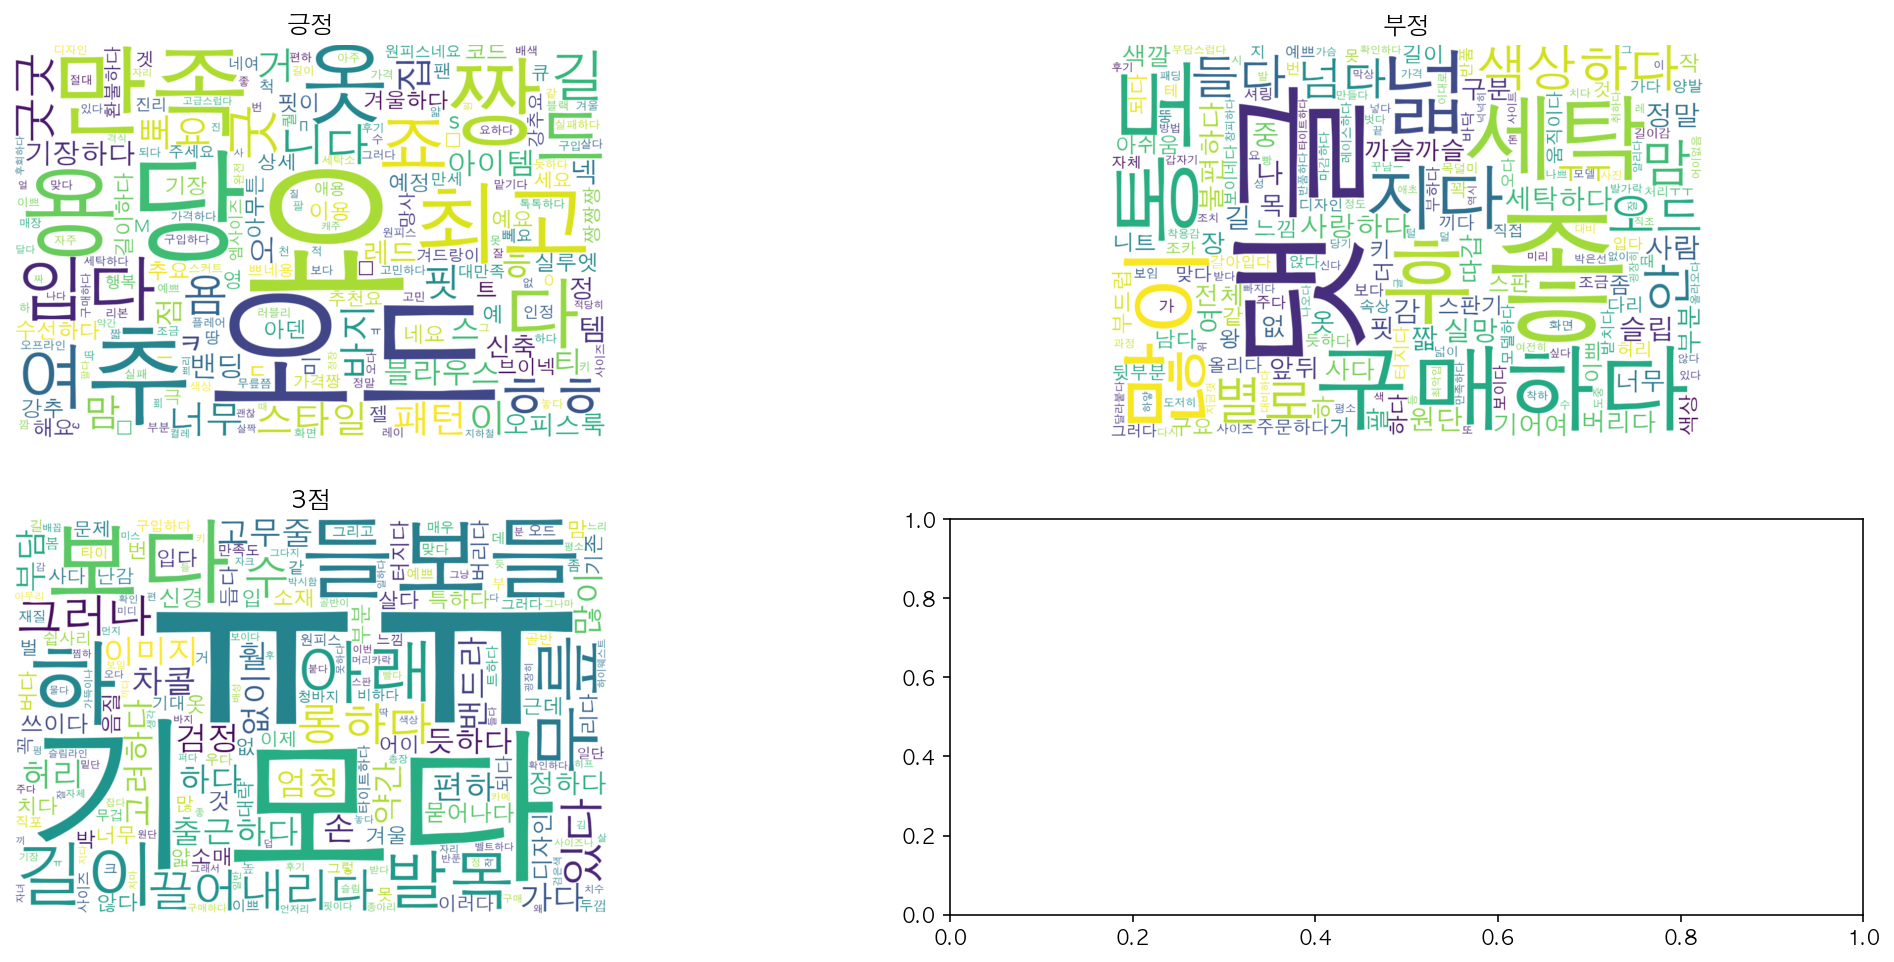

In [176]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

figure.set_size_inches(18, 8)

title_list = ['긍정', '부정', '3점']
reviews_list = [positive_reviews, negative_reviews, neutral_reviews]
ax_list = [ax1, ax2, ax3]

for reviews, ax, title in zip(reviews_list, ax_list, title_list):
    word_list = make_word_list(reviews['tokenized_message'])
    plot_wordcloud(word_list, ax)
    ax.set_title(title)

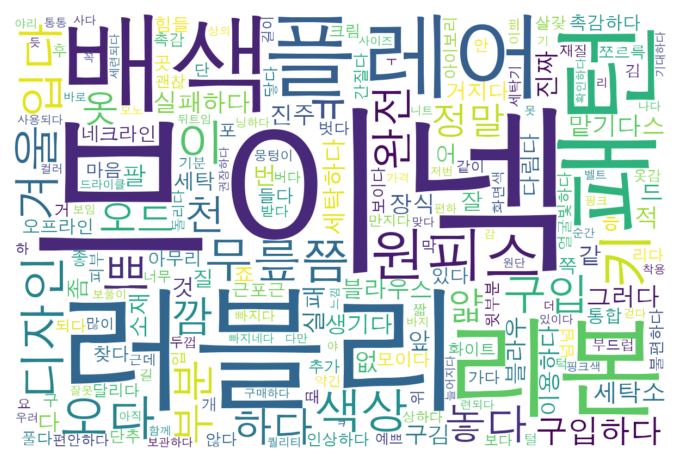

In [177]:
# 세탁 키워드가 들어간 
df = positive_reviews.loc[positive_reviews['tokenized_message'].str.contains("세탁"), 'tokenized_message']

plot_wordcloud(make_word_list(df), plt.axes())

불용어 제외가 시급하다...

----

- [한글 관련 라이브러리](wikidocs.net/92961)
    - https://awesomeopensource.com/projects/korean-nlp
    - https://github.com/datanada/Awesome-Korean-NLP
    
- API
    - [Google NL API](Natural Language) : 90일 무료
    - Amazon
    - https://aiopen.etri.re.kr/service_api.php
    - https://github.com/drexly/openhgsenti
    